In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import epidemic_model_classes_numba as epi_mod
from scipy.integrate import odeint
import scipy.stats as st
from scipy.stats import pearsonr
import os
from tqdm import tqdm

In [2]:
country = "Brazil"
country_folder = "Brazil_adaptive_vs_fixed"
country_file_name = "brazil"
window_size = 20

log_adap = []
log_fix = []

for folder in os.listdir("../logs/sdumont"):
    if "adaptive_Brazil_SEIRD2_3_posts" in folder and f"{window_size}_day" in folder and "True" in folder:
        log_adap.append("../logs/sdumont/"+folder+"/")
    elif "fixed_Brazil_1000_samples_SEIRD_3_posts" in folder and f"{window_size}_day" in folder and "True" in folder:
        log_fix.append("../logs/sdumont/"+folder+"/")

In [3]:
log_fix

['../logs/sdumont/log2021-09-20_23-40-39_fixed_Brazil_1000_samples_SEIRD_3_posts_20_day-window_past_True/',
 '../logs/sdumont/log2021-09-20_23-01-40_fixed_Brazil_1000_samples_SEIRD_3_posts_20_day-window_past_True/',
 '../logs/sdumont/log2021-09-20_23-54-04_fixed_Brazil_1000_samples_SEIRD_3_posts_20_day-window_past_True/',
 '../logs/sdumont/log2021-09-20_23-28-15_fixed_Brazil_1000_samples_SEIRD_3_posts_20_day-window_past_True/',
 '../logs/sdumont/log2021-09-20_23-14-28_fixed_Brazil_1000_samples_SEIRD_3_posts_20_day-window_past_True/']

In [4]:
log_adap

['../logs/sdumont/log2021-08-24_16-53-16_adaptive_Brazil_SEIRD2_3_posts_20_day-window_past_True/',
 '../logs/sdumont/log2021-08-24_18-30-02_adaptive_Brazil_SEIRD2_3_posts_20_day-window_past_True/',
 '../logs/sdumont/log2021-08-24_18-58-39_adaptive_Brazil_SEIRD2_3_posts_20_day-window_past_True/',
 '../logs/sdumont/log2021-08-24_17-57-22_adaptive_Brazil_SEIRD2_3_posts_20_day-window_past_True/',
 '../logs/sdumont/log2021-08-24_17-25-23_adaptive_Brazil_SEIRD2_3_posts_20_day-window_past_True/']

In [5]:
if country_folder not in os.listdir("paper_daora"):
    os.mkdir(f"paper_daora/{country_folder}")
if str(window_size) not in os.listdir(f"paper_daora/{country_folder}"):
    os.mkdir(f"paper_daora/{country_folder}/{str(window_size)}")

In [6]:
n_post_fix = len(os.listdir(log_fix[0]))-1
n_post_adap = len(os.listdir(log_adap[0]))-1
days_folders = os.listdir(log_fix[0]+f"Posterior1/{country}/SEIRD")
for i in range(len(days_folders)):
    days_folders[i] = int(days_folders[i].split("_")[0])
days_folders.sort()
n_window = len(days_folders)

print(n_post_fix)
print(n_post_adap)
print(n_window)
print(days_folders)

3
3
78
[20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405]


In [7]:
seird = epi_mod.SEIRD
seird2 = epi_mod.SEIRD2

In [8]:
x_dat_fix = np.empty((len(log_fix), n_window), dtype=object)
y_fit_fix = np.empty((len(log_fix), n_window), dtype=object)
y_pred_fix = np.zeros((len(log_fix), n_window, 10, 2))

x_dat_adap = np.empty((len(log_adap), n_window), dtype=object)
y_fit_adap = np.empty((len(log_adap), n_window), dtype=object)
y_pred_adap = np.zeros((len(log_adap), n_window, 10, 2))

fix_params = np.zeros((len(log_fix), n_window, 9))
rmsd_fix_fit = np.zeros((len(log_fix), n_window))
rmsd_fix_pred = np.zeros((len(log_fix), n_window))
rmsd_fix_list = np.zeros((len(log_fix), n_window, 10, 2))
fix_tolerances = np.zeros((len(log_fix), n_post_fix, n_window))

adap_params = np.zeros((len(log_adap), n_window, 8))
rmsd_adap_fit = np.zeros((len(log_adap), n_window))
rmsd_adap_pred = np.zeros((len(log_adap), n_window))
rmsd_adap_list = np.zeros((len(log_adap), n_window, 10, 2))
adap_tolerances = np.zeros((len(log_adap), n_post_adap, n_window))

post_fix_size = np.zeros((len(log_fix), n_window), dtype=np.int64)
post_adap_size = np.zeros((len(log_adap), n_window), dtype=np.int64)

In [9]:
for log_idx in range(len(log_fix)):
    for window in tqdm(range(n_window)):
        data = np.loadtxt(log_fix[log_idx]+f"Posterior1/{country}/SEIRD/"+str(days_folders[window])+"_days/data.txt")
        for i in range(1, data.shape[0]):
            for j in range(data.shape[1]):
                if data[i,j] < data[i-1,j]:
                    data[i,j] = data[i-1,j]
        np.savetxt(log_fix[log_idx]+f"Posterior1/{country}/SEIRD/"+str(days_folders[window])+"_days/data.txt", data)
        
        x_dat_fix[log_idx, window] = np.loadtxt(log_fix[log_idx]+f"Posterior1/{country}/SEIRD/"+str(days_folders[window])+"_days/data.txt")[:,0]
        y_fit_fix[log_idx, window] = np.loadtxt(log_fix[log_idx]+f"Posterior1/{country}/SEIRD/"+str(days_folders[window])+"_days/data.txt")[:-10,1:]
        y_pred_fix[log_idx, window] = np.loadtxt(log_fix[log_idx]+f"Posterior1/{country}/SEIRD/"+str(days_folders[window])+"_days/data.txt")[-10:,1:]
        
        log = open(log_fix[log_idx]+f"Posterior3/{country}/SEIRD/"+str(days_folders[window])+"_days/SEIRD_log.out")
        rmsd_fix_list[log_idx, window] = np.loadtxt(log_fix[log_idx]+f"Posterior3/{country}/SEIRD/"+str(days_folders[window])+"_days/val_error.txt")
        fix_params[log_idx, window] = np.loadtxt(log_fix[log_idx]+f"Posterior3/{country}/SEIRD/"+str(days_folders[window])+"_days/best_params.txt")
        log_text = log.read().split("\n")
        
        for line in log_text:
            if "Weighted RMSD:" in line:
                rmsd_fix_fit[log_idx, window] = float(line.split(" ")[-1])
            if "RMSD for validation data:" in line:
                rmsd_fix_pred[log_idx, window] = float(line.split(" ")[-1])
            if "Training window size:" in line:
                    post_fix_size[log_idx, window] = int(line.split(" ")[-1])
        
        for post in range(n_post_fix):
            log = open(log_fix[log_idx]+"Posterior"+str(post+1)+f"/{country}/SEIRD/"+str(days_folders[window])+"_days/SEIRD_log.out")
            
            log_text = log.read().split("\n")
            
            for line in log_text:
                if "Tolerance:" in line:
                    fix_tolerances[log_idx, post, window] = float(line.split(" ")[-1])
                
            log = open(log_fix[log_idx]+"Posterior"+str(post+1)+f"/{country}/SEIRD/"+str(days_folders[window])+"_days/SEIRD_log.out")

            for line in log_text:
                if "Tolerance:" in line:
                    fix_tolerances[log_idx, post, window] = float(line.split(" ")[-1])
                
for log_idx in range(len(log_adap)):
    for window in tqdm(range(n_window)):
        data = np.loadtxt(log_adap[log_idx]+f"Posterior1/{country}/SEIRD2/"+str(days_folders[window])+"_days/data.txt")
        for i in range(1, data.shape[0]):
            for j in range(data.shape[1]):
                if data[i,j] < data[i-1,j]:
                    data[i,j] = data[i-1,j]
        np.savetxt(log_adap[log_idx]+f"Posterior1/{country}/SEIRD2/"+str(days_folders[window])+"_days/data.txt", data)
        
        x_dat_adap[log_idx, window] = np.loadtxt(log_adap[log_idx]+f"Posterior1/{country}/SEIRD2/"+str(days_folders[window])+"_days/data.txt")[:,0]
        y_fit_adap[log_idx, window] = np.loadtxt(log_adap[log_idx]+f"Posterior1/{country}/SEIRD2/"+str(days_folders[window])+"_days/data.txt")[:-10,1:]
        y_pred_adap[log_idx, window] = np.loadtxt(log_adap[log_idx]+f"Posterior1/{country}/SEIRD2/"+str(days_folders[window])+"_days/data.txt")[-10:,1:]
        
        log = open(log_adap[log_idx]+f"Posterior3/{country}/SEIRD2/"+str(days_folders[window])+"_days/SEIRD_log.out")
        rmsd_adap_list[log_idx, window] = np.loadtxt(log_adap[log_idx]+f"Posterior3/{country}/SEIRD2/"+str(days_folders[window])+"_days/val_error.txt")
        adap_params[log_idx, window] = np.loadtxt(log_adap[log_idx]+f"Posterior3/{country}/SEIRD2/"+str(days_folders[window])+"_days/best_params.txt")
        log_text = log.read().split("\n")
        
        for line in log_text:
            if "Weighted RMSD:" in line:
                rmsd_adap_fit[log_idx, window] = float(line.split(" ")[-1])
            if "RMSD for validation data:" in line:
                rmsd_adap_pred[log_idx, window] = float(line.split(" ")[-1])
            if "Training window size:" in line:
                post_adap_size[log_idx, window] = int(line.split(" ")[-1])
        
        for post in range(n_post_adap):
            log = open(log_adap[log_idx]+"Posterior"+str(post+1)+f"/{country}/SEIRD2/"+str(days_folders[window])+"_days/SEIRD_log.out")
            
            log_text = log.read().split("\n")
            
            for line in log_text:
                if "Tolerance:" in line:
                    adap_tolerances[log_idx, post, window] = float(line.split(" ")[-1])
                
            log = open(log_adap[log_idx]+"Posterior"+str(post+1)+f"/{country}/SEIRD2/"+str(days_folders[window])+"_days/SEIRD_log.out")

            for line in log_text:
                if "Tolerance:" in line:
                    adap_tolerances[log_idx, post, window] = float(line.split(" ")[-1])

100%|██████████| 78/78 [00:14<00:00,  5.23it/s]


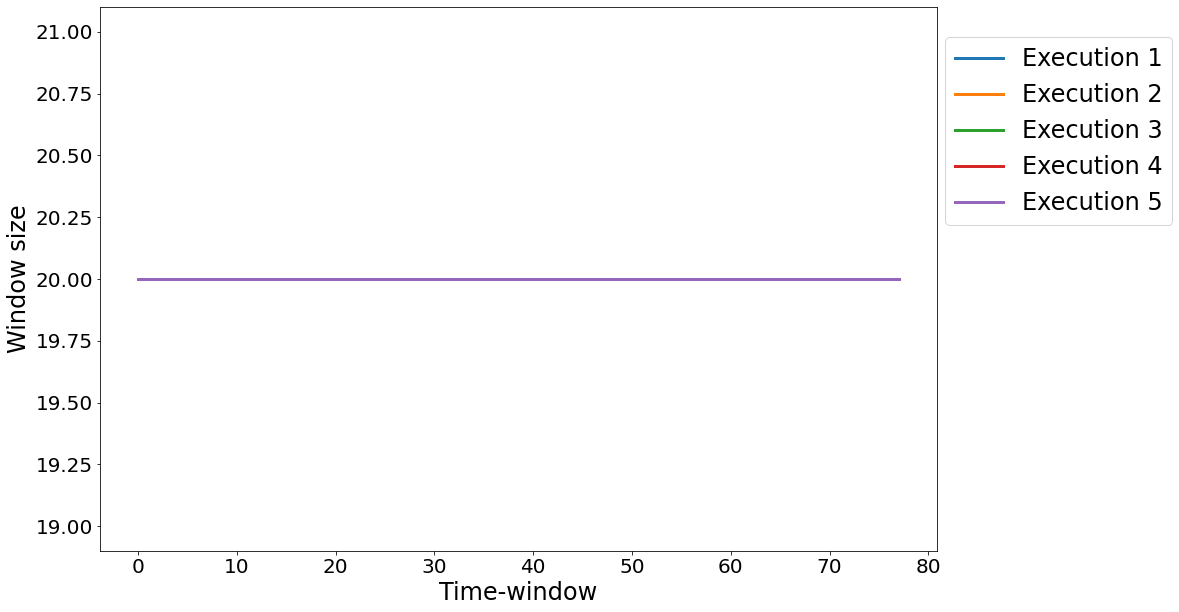

In [10]:
plt.figure(figsize=(15,10))
for i in range(len(log_fix)):
    plt.plot(post_fix_size[i], lw=3, label=f"Execution {i+1}")
plt.legend(loc=(1.01, 0.6), fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Time-window", fontsize=24)
plt.ylabel("Window size", fontsize=24)
plt.savefig(f"paper_daora/{country_folder}/{window_size}/{country_file_name}_{window_size}_window_size_fix.png", dpi=300, bbox_inches="tight")

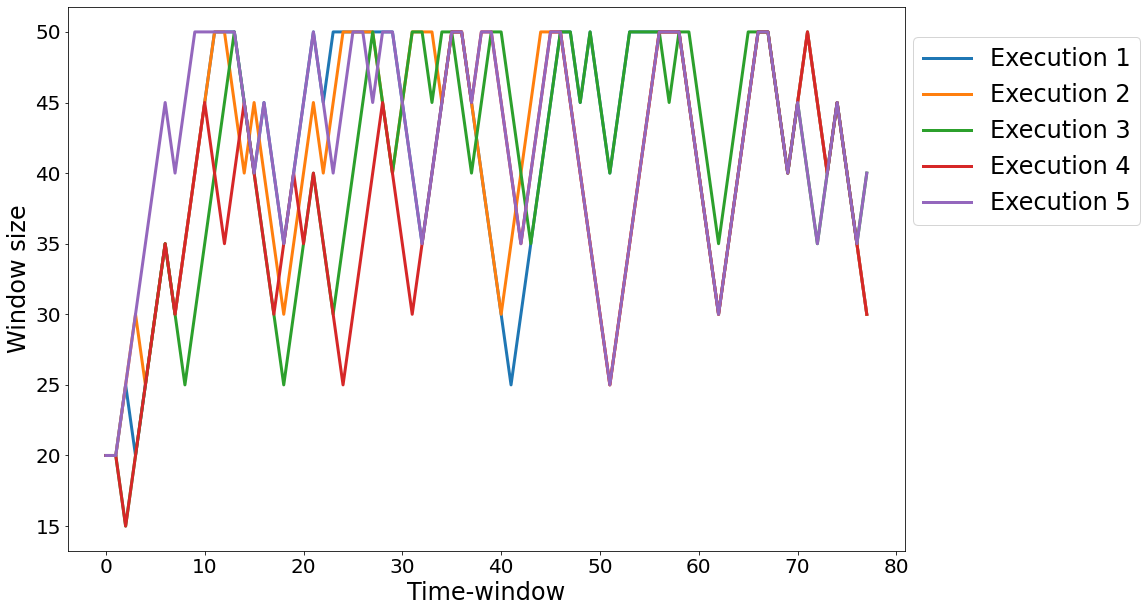

In [11]:
plt.figure(figsize=(15,10))
for i in range(len(log_adap)):
    plt.plot(post_adap_size[i], lw=3, label=f"Execution {i+1}")
plt.legend(loc=(1.01, 0.6), fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Time-window", fontsize=24)
plt.ylabel("Window size", fontsize=24)
plt.savefig(f"paper_daora/{country_folder}/{window_size}/{country_file_name}_{window_size}_window_size_adap.png", dpi=300, bbox_inches="tight")

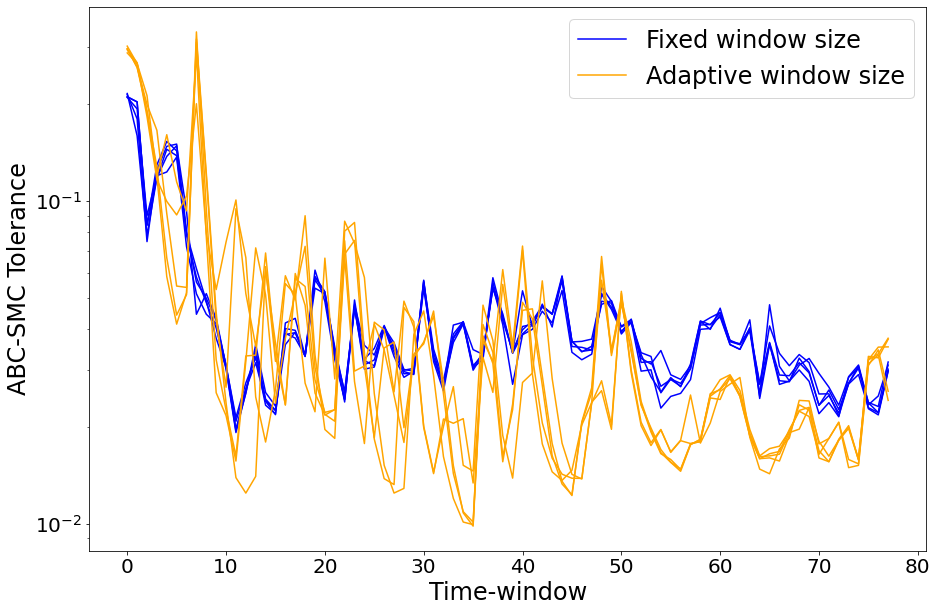

In [12]:
plt.figure(figsize=(15,10))
for i in range(len(log_fix)):
    if i == 1:
        plt.plot(fix_tolerances[i,-1,:].T, c="blue", label="Fixed window size")
    else:
        plt.plot(fix_tolerances[i,-1,:].T, c="blue")
for i in range(len(log_adap)):
    if i == 1:
        plt.plot(adap_tolerances[i,-1,:].T, c="orange", label="Adaptive window size")
    else:
        plt.plot(adap_tolerances[i,-1,:].T, c="orange")
plt.legend(loc="upper right", fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Time-window", fontsize=24)
plt.ylabel("ABC-SMC Tolerance", fontsize=24)
plt.yscale("log")
plt.savefig(f"paper_daora/{country_folder}/{window_size}/{country_file_name}_{window_size}_tolerances.png", dpi=300, bbox_inches="tight")

Fixed 0.022195141025641026
adap 0.018470007692307694


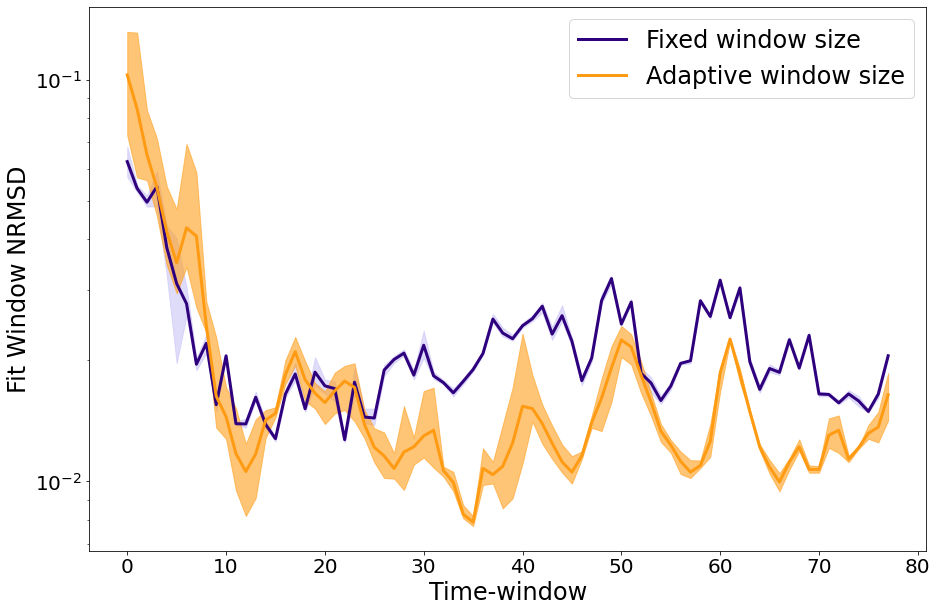

In [13]:
plt.figure(figsize=(15,10))
plt.plot(np.mean(rmsd_fix_fit, axis=0), lw=3, color="#2f007d", label="Fixed window size")
plt.fill_between(np.arange(len(rmsd_fix_fit[0])), np.min(rmsd_fix_fit, axis=0), np.max(rmsd_fix_fit, axis=0), alpha=0.6, color="#cac5f8")
plt.plot(np.mean(rmsd_adap_fit, axis=0), lw=3, color="#ff9b13", label="Adaptive window size")
plt.fill_between(np.arange(len(rmsd_fix_fit[0])), np.min(rmsd_adap_fit, axis=0), np.max(rmsd_adap_fit, axis=0), alpha=0.6, color="#ff9f1d")
plt.legend(loc="upper right", fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Time-window", fontsize=24)
plt.ylabel("Fit Window NRMSD", fontsize=24)
plt.yscale("log")
plt.savefig(f"paper_daora/{country_folder}/{window_size}/{country_file_name}_{window_size}_fit_window_nrmsd.png", dpi=300, bbox_inches="tight")
print("Fixed", np.mean(rmsd_fix_fit))
print("adap", np.mean(rmsd_adap_fit))

Fixed 0.2170128076923077
adap 0.3051312948717949


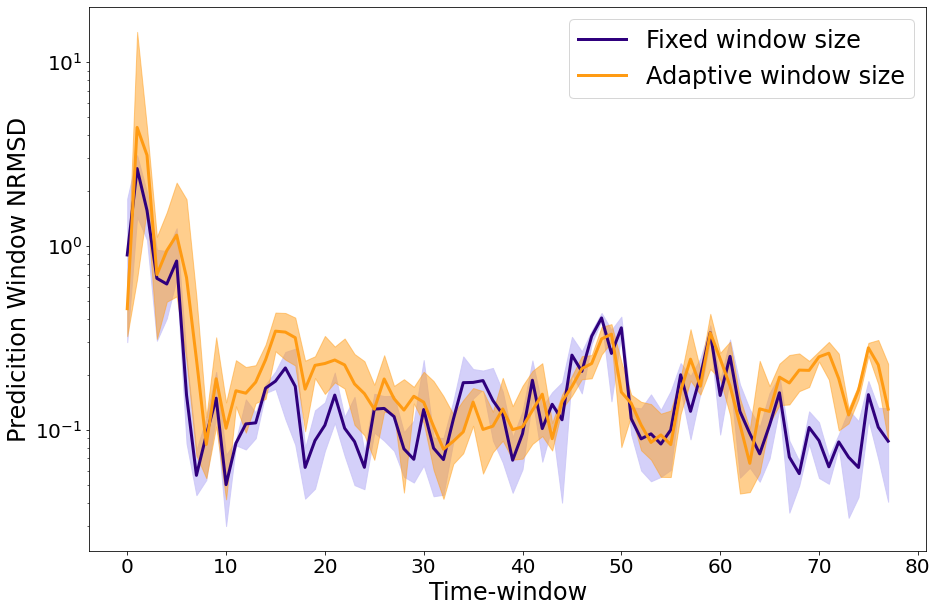

In [14]:
plt.figure(figsize=(15, 10))
plt.plot(np.mean(rmsd_fix_pred, axis=0), lw=3, color="#2f007d", label="Fixed window size")
plt.fill_between(np.arange(len(rmsd_fix_pred[0])), np.min(rmsd_fix_pred, axis=0), np.max(rmsd_fix_pred, axis=0), alpha=0.8, color="#cac5f8")
plt.plot(np.mean(rmsd_adap_pred, axis=0), lw=3, color="#ff9b13", label="Adaptive window size")
plt.fill_between(np.arange(len(rmsd_fix_pred[0])), np.min(rmsd_adap_pred, axis=0), np.max(rmsd_adap_pred, axis=0), alpha=0.5, color="#ff9f1d")
plt.legend(loc="upper right", fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Time-window", fontsize=24)
plt.ylabel("Predicition Window NRMSD", fontsize=24)
plt.yscale("log")
plt.savefig(f"paper_daora/{country_folder}/{window_size}/{country_file_name}_{window_size}_pred_window_nrmsd.png", dpi=300, bbox_inches="tight")
print("Fixed", np.mean(rmsd_fix_pred))
print("adap", np.mean(rmsd_adap_pred))

In [15]:
rmsd_fix_list_norm = np.abs((y_pred_fix[:,:,1:]-rmsd_fix_list[:,:,1:])-(y_pred_fix[:,:,:-1]-rmsd_fix_list[:,:,:-1])-(y_pred_fix[:,:,1:]-y_pred_fix[:,:,:-1]))/(y_pred_fix[:,:,1:]-y_pred_fix[:,:,:-1]+1)
rmsd_adap_list_norm = np.abs((y_pred_adap[:,:,1:]-rmsd_adap_list[:,:,1:])-(y_pred_adap[:,:,:-1]-rmsd_adap_list[:,:,:-1])-(y_pred_adap[:,:,1:]-y_pred_adap[:,:,:-1]))/(y_pred_adap[:,:,1:]-y_pred_adap[:,:,:-1]+1)

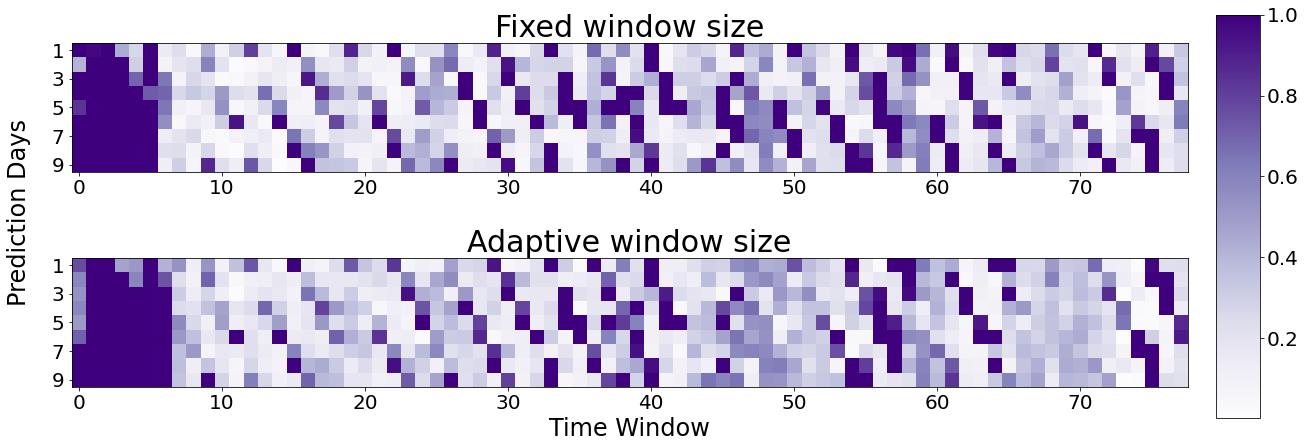

In [16]:
# plt.rcParams.update({"font.size":36})
fig = plt.figure(figsize=(20,7))
plt.subplots_adjust(hspace=0.3)
plt.subplot(2,1,1)
pl = plt.imshow(np.mean(rmsd_fix_list_norm[:,:,:,0], axis=0).T, vmax=1, cmap="Purples")
plt.yticks(range(0,10,2), labels=range(1,11,2), fontsize=20)
plt.xticks(fontsize=20)
plt.title("Fixed window size", fontsize=30)
plt.subplot(2,1,2)
plt.imshow(np.mean(rmsd_adap_list_norm[:,:,:,0], axis=0).T, vmax=1, cmap="Purples")
plt.yticks(range(0,10,2), labels=range(1,11,2), fontsize=20)
plt.xticks(fontsize=20)
plt.title("Adaptive window size", fontsize=30)
plt.xlabel("Time Window", fontsize=24)
plt.text(-5, 2.5, "Prediction Days", rotation="vertical", fontsize=24)
cb_ax = fig.add_axes([0.92, 0.1, 0.03, 0.8])
cb = fig.colorbar(pl, cax=cb_ax)
cb.ax.tick_params(labelsize=20)
plt.savefig(f"paper_daora/{country_folder}/{window_size}/{country_file_name}_{window_size}_heatmap.png", dpi=300, bbox_inches="tight")

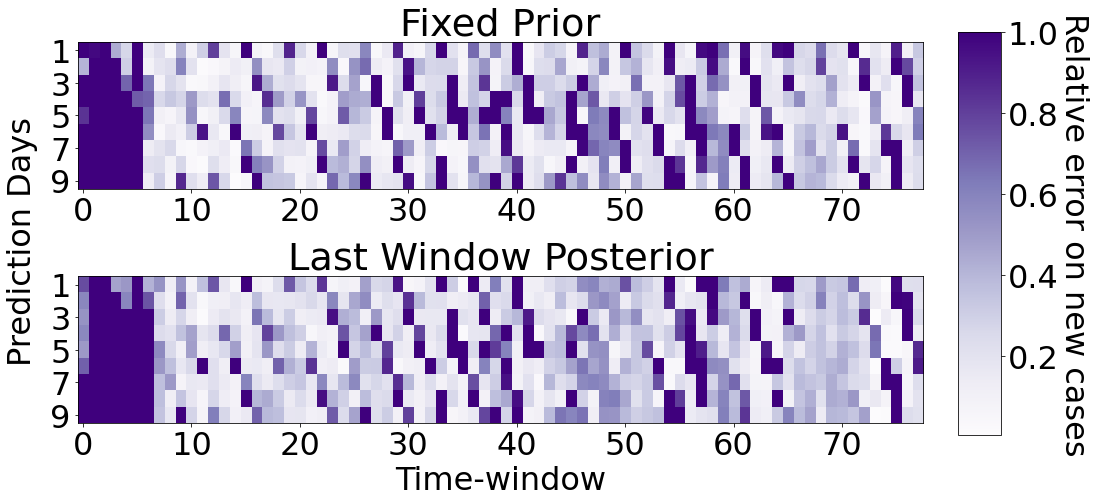

In [17]:
plt.rcParams.update({"font.size":32})
fig = plt.figure(figsize=(20,7))
# fig, ax = plt.subplots(2,1,sharey=True)
plt.subplots_adjust(hspace=0.6)
plt.subplot(2,1,1)
pl = plt.imshow(np.mean(rmsd_fix_list_norm[:,:,:,0], axis=0).T, vmax=1, cmap="Purples", aspect=1.5)
plt.yticks(range(0,10,2), labels=range(1,11,2))
plt.title("Fixed Prior")
plt.subplot(2,1,2)
plt.imshow(np.mean(rmsd_adap_list_norm[:,:,:,0], axis=0).T, vmax=1, cmap="Purples", aspect=1.5)
plt.yticks(range(0,10,2), labels=range(1,11,2))
plt.title("Last Window Posterior")
plt.xlabel("Time-window")
plt.text(-7, 4.5, "Prediction Days", rotation="vertical")
cb_ax = fig.add_axes([0.83, 0.1, 0.03, 0.8])

cbar = fig.colorbar(pl, cax=cb_ax)
cbar.set_label("Relative error on new cases", rotation=-90, labelpad=30)
# plt.tight_layout()
# plt.savefig("flat_vs_past_heatmap.pdf", bbox_inches="tight")

In [19]:
pearsonr(rmsd_fix_fit.flatten(), rmsd_fix_pred.flatten())

(0.7165172697295502, 1.1557839391927818e-62)

In [20]:
pearsonr(rmsd_adap_fit.flatten(), rmsd_adap_pred.flatten())

(0.4960088918554131, 1.3051906644230038e-25)

---

# R0

def R0(beta, beta_E, mu, gamma, tau):
    return ((gamma+mu)*beta_E + beta/tau)/((gamma + mu)/tau)

df = pd.read_csv('../data/owid-covid-data.csv')

uk = df.loc[df['location'] == country]
uk['date'] = pd.to_datetime(uk['date'], format = '%Y-%m-%d')

daily = np.array(uk['new_cases_smoothed'].values)
rt = np.array(uk['reproduction_rate'].values)

daily = np.nan_to_num(daily)
rt = np.nan_to_num(rt)

def R0(beta, beta_E, mu, gamma, tau):
    return beta_E*tau + beta/(gamma+mu)

data_path = log_fix[0]+f"Posterior3/{country}/SEIRD2"

window_sizes = post_flat_size[0]

days = np.arange(1, days_folders[-1])
r0 = np.zeros(len(days))

for i in tqdm(range(len(days))):
    count_overlap = 0
    for window_idx in range(np.searchsorted(days_folders, days[i]), min(len(days_folders), np.searchsorted(days_folders, days[i])+10)):
        if days[i] >= days_folders[window_idx] - window_sizes[window_idx]:
            post = np.loadtxt(f'{data_path}/{days_folders[window_idx]}_days/post.txt')
            post = post[np.argsort(post[:,-1])]
            r = 0
            for j in range(1):
                beta = post[j,0]
                beta_E = post[j,1]
                mu = post[j,3]
                gamma = post[j,4]
                tau = post[j,5]
                r += R0(beta, beta_E, mu, gamma, tau)
            r0[i] += r/1
            count_overlap += 1
    r0[i] /= count_overlap

plt.plot(r0)

data_path = log_adap[0]+f"Posterior3/{country}/SEIRD2"

window_sizes = post_past_size[0]

days = np.arange(1, days_folders[-1])
r0 = np.zeros(len(days))

for i in tqdm(range(len(days))):
    count_overlap = 0
    for window_idx in range(np.searchsorted(days_folders, days[i]), min(len(days_folders), np.searchsorted(days_folders, days[i])+10)):
        if days[i] >= days_folders[window_idx] - window_sizes[window_idx]:
            post = np.loadtxt(f'{data_path}/{days_folders[window_idx]}_days/post.txt')
            post = post[np.argsort(post[:,-1])]
            r = 0
            for j in range(15):
                beta = post[j,0]
                beta_E = post[j,1]
                mu = post[j,3]
                gamma = post[j,4]
                tau = post[j,5]
                r += R0(beta, beta_E, mu, gamma, tau)
            r0[i] += r/15
            count_overlap += 1
    r0[i] /= count_overlap

plt.plot(r0)
plt.hlines(1, 0, 430)

---

# Subplots - Flat

In [18]:
plt.subplots(int(np.ceil(n_window/8)), 8, figsize=(40, 50))
plt.subplots_adjust(hspace=0.3, wspace=0.2)

y0 = np.zeros(5)

for i in range(n_window, int(np.ceil(n_window/8))*8):
    plt.subplot(int(np.ceil(n_window/8)), 8, i+1)
    plt.axis("off")

for i in tqdm(range(n_window)):
    y_fit = np.zeros((len(log_fix), 60))
    x_len = 0
    x_max_len_idx = -1
    
    for log_idx in range(len(log_fix)):
        if len(x_dat_flat[log_idx, i]) > x_len:
            x_len = len(x_dat_flat[log_idx, i])
            x_max_length_idx = log_idx
        
        y0[-1] = y_fit_flat[log_idx, i][0,1]
        y0[-2] = y_fit_flat[log_idx, i][0,0] - y0[-1]
        
        y_fit[log_idx,-len(x_dat_flat[log_idx, i]):] = seird.infected_dead(x_dat_flat[log_idx, i], flat_params[log_idx, i], y0)[0]
    
    y_fit_avg = np.zeros(x_len)
    y_fit_std = np.zeros(x_len)
    
    for j in range(x_len):
        y = []
        for k in range(len(log_fix)):
            if y_fit[k,j-x_len] != 0:
                y.append(y_fit[k,j-x_len])
        y_fit_avg[j] = np.mean(y)
        y_fit_std[j] = np.std(y)

    plt.subplot(int(np.ceil(n_window/8)), 8, i+1)
    plt.plot(x_dat_flat[x_max_length_idx, i][:-10], y_fit_flat[x_max_length_idx, i][:,0], "o", ms=3, c="k")
    plt.plot(x_dat_flat[x_max_length_idx, i][-10:], y_pred_flat[x_max_length_idx, i,:,0], "o", ms=3, c="#808080")
    plt.ticklabel_format(axis="y", scilimits=(0,1))
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.gca().yaxis.get_offset_text().set_fontsize(10)
    
    plt.title(f"Time-window {x_dat_flat[x_max_length_idx, i][0]:.0f}-{x_dat_flat[x_max_length_idx, i][-1]:.0f}", fontsize=18)
    
    plt.plot(x_dat_flat[x_max_length_idx, i], y_fit_avg, lw=2)
    plt.fill_between(x_dat_flat[x_max_length_idx, i], y_fit_avg-y_fit_std, y_fit_avg+y_fit_std, alpha=0.3)
    
    plt.vlines(np.mean(x_dat_flat[x_max_length_idx, i][-11:-9]), y_fit_flat[x_max_length_idx, i][0,0], max(y_pred_flat[x_max_length_idx, i,-1,0], y_fit_avg[-1]+y_fit_std[-1]), color="#202020", ls="--", lw=1)
    
plt.savefig(f"paper_daora/{country}/{window_size}/{country_file_name}_{window_size}_windows_flat.png", dpi=300, bbox_inches="tight")
plt.close()

100%|██████████| 83/83 [00:10<00:00,  7.98it/s]


In [19]:
plt.subplots(int(np.ceil(n_window/8)), 8, figsize=(40, 50))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

y0 = np.zeros(5)

for i in range(n_window, int(np.ceil(n_window/8))*8):
    plt.subplot(int(np.ceil(n_window/8)), 8, i+1)
    plt.axis("off")

for i in tqdm(range(n_window)):
    y_fit = np.zeros((len(log_adap), 60))
    x_len = 0
    x_max_len_idx = -1
    
    for log_idx in range(len(log_adap)):
        if len(x_dat_past[log_idx, i]) > x_len:
            x_len = len(x_dat_past[log_idx, i])
            x_max_length_idx = log_idx
        
        y0[-1] = y_fit_past[log_idx, i][0,1]
        y0[-2] = y_fit_past[log_idx, i][0,0] - y0[-1]
        
        y_fit[log_idx,-len(x_dat_past[log_idx, i]):] = seird.infected_dead(x_dat_past[log_idx, i], past_params[log_idx, i], y0)[0]
    
    y_fit_avg = np.zeros(x_len)
    y_fit_std = np.zeros(x_len)
    
    for j in range(x_len):
        y = []
        for k in range(len(log_adap)):
            if y_fit[k,j-x_len] != 0:
                y.append(y_fit[k,j-x_len])
        y_fit_avg[j] = np.mean(y)
        y_fit_std[j] = np.std(y)

    plt.subplot(int(np.ceil(n_window/8)), 8, i+1)
    plt.plot(x_dat_past[x_max_length_idx, i][:-10], y_fit_past[x_max_length_idx, i][:,0], "o", ms=3, c="k")
    plt.plot(x_dat_past[x_max_length_idx, i][-10:], y_pred_past[x_max_length_idx, i, :,0], "o", ms=3, c="#808080")
    plt.ticklabel_format(axis="y", scilimits=(0,1))
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.gca().yaxis.get_offset_text().set_fontsize(10)
    
    plt.title(f"Time-window {x_dat_past[x_max_length_idx, i][0]:.0f}-{x_dat_past[x_max_length_idx, i][-1]:.0f}", fontsize=18)
    
    plt.plot(x_dat_past[x_max_length_idx, i], y_fit_avg, lw=2)
    plt.fill_between(x_dat_past[x_max_length_idx, i], y_fit_avg-y_fit_std, y_fit_avg+y_fit_std, alpha=0.3)
    
    plt.vlines(np.mean(x_dat_past[x_max_length_idx, i][-11:-9]), y_fit_past[x_max_length_idx, i][0,0], max(y_pred_past[x_max_length_idx, i,-1,0], y_fit_avg[-1]+y_fit_std[-1]), color="#202020", ls="--", lw=1)

plt.savefig(f"paper_daora/{country}/{window_size}/{country_file_name}_{window_size}_windows_past.png", dpi=300, bbox_inches="tight")
plt.close()

100%|██████████| 83/83 [00:03<00:00, 22.83it/s]
